In [1]:
%matplotlib inline

In [50]:
import numpy as np
import importlib as il
import matplotlib as mpl
import matplotlib.pyplot as plt
import time

In [37]:
#%env NUMBA_ENABLE_CUDASIM=0
import fields.gravity as grav
il.reload(grav)

<module 'fields.gravity' from '/home/solter/workspace/particle_fields/fields/gravity.py'>

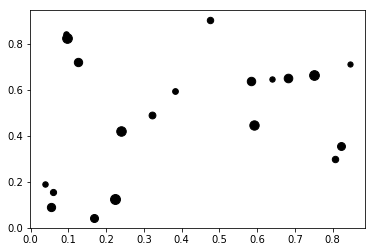

In [4]:
# Random particles
pos = np.random.random([20,3])
pos[:,2] = 1
mass = 10*np.random.random([20])+10

# Plot them
for i in range(20):
    plt.plot(pos[i,0], pos[i,1], marker='o', markersize=mass[i]/2, color='black')

In [45]:
# Specific particles
pos = np.array([[0, 0, 1.],
                 [1, 1, 1.]])
mass = np.array([10, 10])

In [40]:
sp_bound, U_g = grav.calcGravitationalPotential(pos, mass, useCuda=True)
xs = np.linspace(sp_bound[0,0], sp_bound[0,1], U_g.shape[0])
ys = np.linspace(sp_bound[1,0], sp_bound[1,1], U_g.shape[1])
print("xs: {}\nys: {}\nU_g: {}".format(xs.shape, ys.shape, U_g.shape))

xs: (128,)
ys: (128,)
U_g: (128, 128, 1)


In [46]:
%%timeit
sp_bound, U_g = grav.calcGravitationalPotential(pos, mass, useCuda=True)

1.5 ms ± 7.82 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [47]:
%%timeit
sp_bound, U_g = grav.calcGravitationalPotential(pos, mass, useCuda=False)

765 µs ± 45.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [80]:
# Check performance of numpy field vs gpu
npart_list2 = [2**i for i in range(2,10)]
cuda_time2 = np.zeros(len(npart_list2))
numpy_time2 = np.zeros(len(npart_list2))
nloops = 100

for i, npart in enumerate(npart_list2):
    # Random particles
    pos = np.random.random([npart,3])
    pos[:,2] = 1
    mass = 10*np.random.random([npart])+10
    
    for j in range(nloops):
        # Do it the cuda way
        start_time = time.time()
        grav.calcGravitationalPotential(pos, mass, useCuda=True)
        end_time = time.time()
        cuda_time2[i] += end_time - start_time
        
        # Do it the Numpy way
        start_time = time.time()
        grav.calcGravitationalPotential(pos, mass, useCuda=False)
        end_time = time.time()
        numpy_time2[i] += end_time - start_time
        
    cuda_time2[i] /= nloops
    numpy_time2[i] /= nloops    

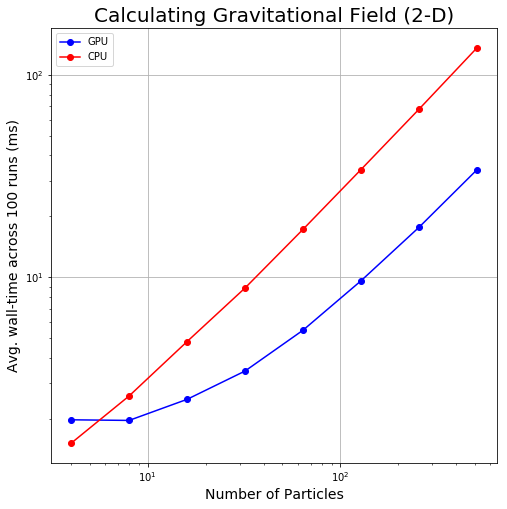

In [87]:
plt.figure(figsize=(8,8))
plt.loglog(npart_list2, cuda_time2*1000, color='blue', marker='o', label='GPU')
plt.loglog(npart_list2, numpy_time2*1000, color='red', marker='o', label='CPU')
plt.legend()
plt.ylabel("Avg. wall-time across 100 runs (ms)", fontsize=14)
plt.xlabel("Number of Particles", fontsize=14)
plt.grid()
plt.title("Calculating Gravitational Field (2-D)", fontsize=20)

In [81]:
# Check performance of numpy field vs gpu
npart_list3 = [2**i for i in range(2,10)]
cuda_time3 = np.zeros(len(npart_list))
numpy_time3 = np.zeros(len(npart_list))
nloops = 100

for i, npart in enumerate(npart_list3):
    # Random particles
    pos = np.random.random([npart,3])
    mass = 10*np.random.random([npart])+10
    
    for j in range(nloops):
        # Do it the cuda way
        start_time = time.time()
        grav.calcGravitationalPotential(pos, mass, useCuda=True)
        end_time = time.time()
        cuda_time3[i] += end_time - start_time
        
        # Do it the Numpy way
        start_time = time.time()
        grav.calcGravitationalPotential(pos, mass, useCuda=False)
        end_time = time.time()
        numpy_time3[i] += end_time - start_time
        
    cuda_time3[i] /= nloops
    numpy_time3[i] /= nloops    

In [95]:
cuda_time3 = cuda_time3[:8]
numpy_time3 = numpy_time3[:8]

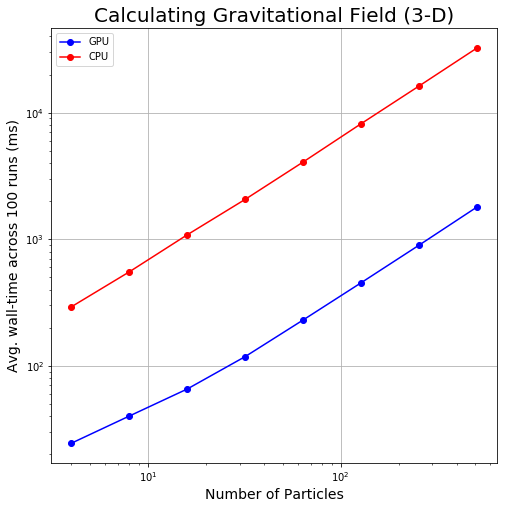

In [97]:
plt.figure(figsize=(8,8))
plt.loglog(npart_list3, cuda_time3*1000, color='blue', marker='o', label='GPU')
plt.loglog(npart_list3, numpy_time3*1000, color='red', marker='o', label='CPU')
plt.legend()
plt.ylabel("Avg. wall-time across 100 runs (ms)", fontsize=14)
plt.xlabel("Number of Particles", fontsize=14)
plt.grid()
plt.title("Calculating Gravitational Field (3-D)", fontsize=20)

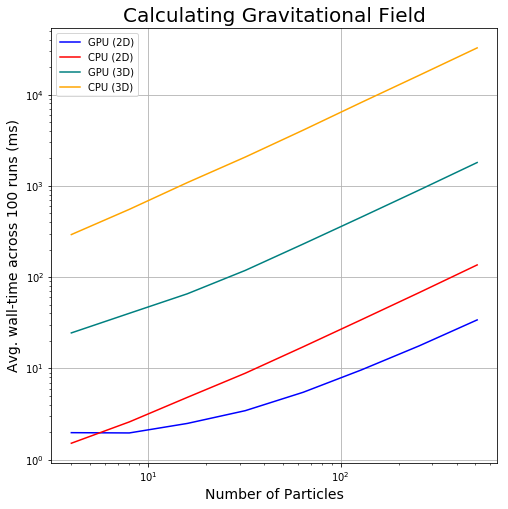

In [100]:
plt.figure(figsize=(8,8))
plt.loglog(npart_list2, cuda_time2*1000, color='blue', label='GPU (2D)')
plt.loglog(npart_list2, numpy_time2*1000, color='red', label='CPU (2D)')
plt.loglog(npart_list3, cuda_time3*1000, color='teal', label='GPU (3D)')
plt.loglog(npart_list3, numpy_time3*1000, color='orange', label='CPU (3D)')
plt.legend()
plt.ylabel("Avg. wall-time across 100 runs (ms)", fontsize=14)
plt.xlabel("Number of Particles", fontsize=14)
plt.grid()
plt.title("Calculating Gravitational Field", fontsize=20)
plt.savefig("timingPlot.png")

In [96]:
import pickle
timing_data = {
    "npart2":npart_list2,
    "npart3":npart_list3,
    "gpu_time_3d":cuda_time3,
    "gpu_time_2d":cuda_time2,
    "cpu_time_3d":numpy_time3,
    "cpu_time_2d":numpy_time2
}
with open('timingData.pkl', 'wb') as f:
    pickle.dump(timing_data, f)
    

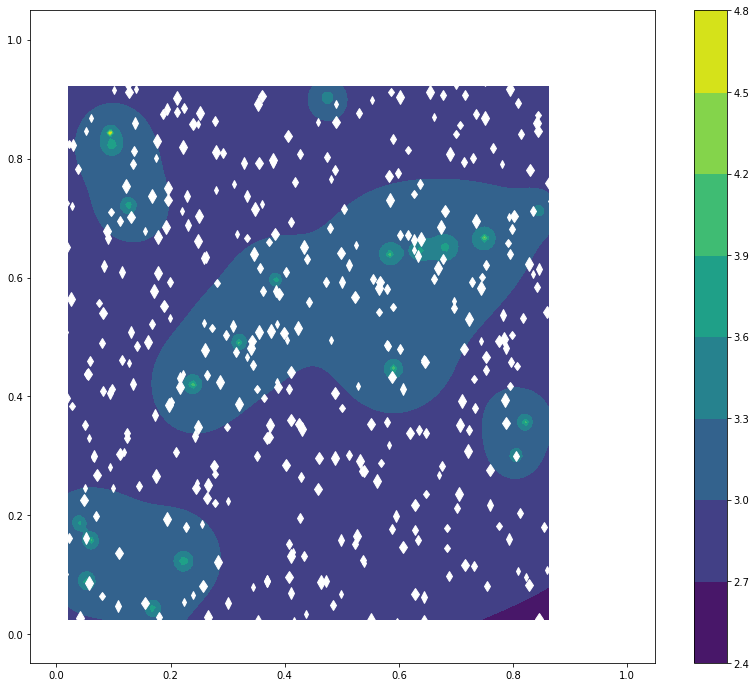

In [55]:
fig, ax = plt.subplots(figsize=[14,12])
cs = ax.contourf(xs, ys, np.transpose(np.log10(abs(U_g[:,:,0]))))
fig.colorbar(cs, ax=ax)
for i in range(len(mass)):
    ax.plot(pos[i,0], pos[i,1], marker='d', markersize=mass[i]/2, color='white')
if False:
    ax.set_xticks(xs)
    ax.set_yticks(ys)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.grid()

In [21]:
xs = [0,1,2,3]
ys = [4,5,6]
zs = [7,8]
XS, YS, ZS = np.meshgrid(xs, ys, zs, indexing='ij')

In [27]:
XS[3,:,:]

array([[3, 3],
       [3, 3],
       [3, 3]])

In [30]:
YS[:,2,:]

array([[6, 6],
       [6, 6],
       [6, 6],
       [6, 6]])

In [32]:
ZS[:,:,1]

array([[8, 8, 8],
       [8, 8, 8],
       [8, 8, 8],
       [8, 8, 8]])